In [1]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_TRACING_v2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "tutorial_chatbot"
os.environ["LANGSMITH_API_KEY"] = ""

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

True

In [3]:
from langsmith import utils
utils.tracing_is_enabled()

True

In [4]:
from langchain_ollama import ChatOllama

model = ChatOllama(model="qwen3")

In [5]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("qwen3", model_provider="ollama")

In [6]:
from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 0


In [9]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


In [11]:
# Add documents to the vector store
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['f2897ab7-fb0c-4bee-8c48-dea0dec8cd8f', '3255904b-5e95-4930-9448-4d7d28177792', '63d55efb-c7dd-4c0e-8262-3134d6b8aa15']


In [12]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Nodes (application steps)
Let's start with a simple sequence of two steps: retrieval and generation.

In [14]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

## Control flow
Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

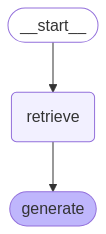

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='63d55efb-c7dd-4c0e-8262-3134d6b8aa15', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='5043944a-05d6-42db-822d-a6bda67b4ae8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372}, page_content="(3) Task execution: Expert models execute on th

In [18]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='63d55efb-c7dd-4c0e-8262-3134d6b8aa15', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='5043944a-05d6-42db-822d-a6bda67b4ae8', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 19372}, page_content="(3) Task execution: Expert mode

In [19]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

<think>|
|Okay|,| the| user| is| asking| about| Task| Decom|position|.| Let| me| check| the| provided| context|.

|The| context| mentions| Task| Decom|position| as| part| of| a| L|LM|-powered| agent| system|.| It| explains| that| Co|T| (|Chain| of| Thought|)| is| a| method| where| the| model| breaks| down| complex| tasks| into| smaller| steps| by| thinking| step| by| step|.| Also|,| Tree| of| Thoughts| extends| this| by| exploring| multiple| reasoning| paths|.| The| answer| should| define| Task| Decom|position|,| mention| Co|T| and| Tree| of| Thoughts| as| methods|,| and| note| that| it|'s| used| to| simplify| complex| tasks|.| Need| to| keep| it| concise|,| three| sentences| max|.| Make| sure| to| use| the| context| provided| and| not| add| extra| info|.
|</think>|

|Task| Decom|position| is| the| process| of| breaking| down| complex| tasks| into| smaller|,| manageable| steps|.| It| lever|ages| methods| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| to| guide| models| in

## Query analysis
So far, we are executing the retrieval using the raw input query. However, there are some advantages to allowing a model to generate the query for retrieval purposes. For example:

In addition to semantic search, we can build in structured filters (e.g., "Find documents since the year 2020.");
The model can rewrite user queries, which may be multifaceted or include irrelevant language, into more effective search queries.
Query analysis employs models to transform or construct optimized search queries from raw user input. We can easily incorporate a query analysis step into our application. For illustrative purposes, let's add some metadata to the documents in our vector store. We will add some (contrived) sections to the document which we can filter on later.

In [20]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

We will need to update the documents in our vector store. We will use a simple InMemoryVectorStore for this, as we will use some of its specific features (i.e., metadata filtering). Refer to the vector store integration documentation for relevant features of your chosen vector store.

In [21]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Let's next define a schema for our search query. We will use structured output for this purpose. Here we define a query as containing a string query and a document section (either "beginning", "middle", or "end"), but this can be defined however you like.

In [22]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

Finally, we add a step to our LangGraph application to generate a query from the user's raw input:

In [23]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

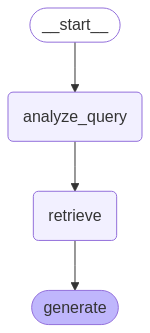

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='944a3041-8900-4eb7-8a55-cac27faf1c45', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

In [26]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [27]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='49423c91-8173-4683-b916-f09841f2ec72', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adjust plans when faced w

In [44]:
from langchain_community.document_loaders import SeleniumURLLoader

loader = SeleniumURLLoader(urls=["https://datastore.bam.de/en/Glossary"])
docs = loader.load()

print(f"Loaded {len(docs)} document(s)")
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:10473])  # preview

Loaded 1 document(s)
Total characters: 10473
/

Glossary

Glossary of openBIS/Data Store terms

¶ Collection

In openBIS, a Collection is a folder with user-defined Properties located on the third level of the hierarchical data structure (Space/Project/Collection/Object). A Collection is always part of a Project. Collections of the same type are described by the same set of Properties. Collection types are defined as part of the openBIS masterdata. Datasets can be attached to Collections. A Collection can logically group an unlimited number of Object of one or more Object types. For instance, a Collection of the type "Measurement Devices" can be used to organize Objects of the type "Instrument" in the Inventory. A Collection of the type "Default Experiment" can be used to organize Objects of the type "Experimental Step" in the Lab Notebook.

uml diagram

¶ Controlled Vocabulary

A controlled vocabulary is an established list of terms to provide consistency and uniqueness in the descrip

In [45]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 14 sub-documents.


In [46]:
# Add documents to the vector store
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['0e327562-c509-484b-bed4-a07cec65b395', '6c2d213a-49af-404d-ac02-4873c643e522', '57e60334-9468-4727-a36d-ea881b53b06a']


In [47]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


## State:
The state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For a simple RAG application, we can just keep track of the input question, retrieved context, and generated answer:

In [48]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Nodes (application steps)
Let's start with a simple sequence of two steps: retrieval and generation.

In [49]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Our retrieval step simply runs a similarity search using the input question, and the generation step formats the retrieved context and original question into a prompt for the chat model.

## Control flow
Finally, we compile our application into a single graph object. In this case, we are just connecting the retrieval and generation steps into a single sequence.

In [50]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

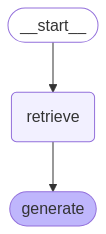

In [51]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
result = graph.invoke({"question": "What does the web says about pyBIS?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='1f1ba6a4-d431-4e7b-8a72-ed073f64ab79', metadata={'source': 'https://datastore.bam.de/en/Glossary', 'title': 'Glossary of openBIS/Data Store terms | Data Store - FDM@BAM', 'description': 'No description found.', 'language': 'en', 'start_index': 9628}, page_content='¶ pyBIS\n\npyBIS is a Python module for interacting with openBIS. Most actions that can be carried out in the openBIS graphical user interface (GUI) can also be done via pyBIS. pyBIS is designed to be most useful in a Jupyter Notebook or IPython environment.\n\n¶ Space\n\nIn openBIS, a Space is a folder located on the first level of the hierarchical data structure (Space/Project/Collection/Object). A Space is either located in the Inventory or in the Lab Notebook. A Space can logically group an unlimited number of Projects. For instance, a Space "Materials" can include the Project "Reagents" in the Inventory. A Space "Master Students" can include the Project "Master Thesis" in the Lab Notebook. Apart fr

In [41]:
from typing import Literal

import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader, SeleniumURLLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = SeleniumURLLoader(urls=["https://datastore.bam.de/en/Glossary"])
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)


# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [42]:
for step in graph.stream(
    {"question": "What does the middle of the post say about Parent-Child Relationship?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Parent-Child Relationship', 'section': 'Middle'}}}

----------------

{'retrieve': {'context': []}}

----------------

{'generate': {'answer': "<think>\nOkay, the user is asking about the middle of the post regarding the Parent-Child Relationship. Let me check the context provided. Wait, the context here is empty. The user probably forgot to include the actual content they want me to reference. Since there's no context given, I can't extract any information. I should inform them that the context is missing. Let me make sure I don't make up any details. Just a straightforward response that I don't have the necessary information. Keep it concise, three sentences max. Alright, that's done.\n</think>\n\nThe context provided is empty, so I cannot answer the question about the middle of the post. Please provide the relevant content for an accurate response."}}

----------------

